In [16]:
import zipfile
from io import BytesIO
from pathlib import Path
from zipfile import ZipFile

import mglyph as mg
import torch
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import Dataset
from torchvision.io import ImageReadMode

import lib
from manifest_parsing import Manifest

# Building the training set

In [3]:
def square(x: float, canvas: mg.Canvas):
    canvas.tr.scale(mg.lerp(x, 0.2, 0.95))
    canvas.rect(canvas.top_left, canvas.bottom_right, color="red")


lib.export_glyph(square, name="square", glyph_set="1")

IntProgress(value=0, description='Exporting square 1.0.0:', max=1000, style=ProgressStyle(bar_color='cornflowe…

Exporting square 1.0.0 finished!


In [4]:
# here, we need to load the glyph and convert it into a format that'll be accepted by the NN
glyph_location: str = "data/glyphs-1/square.mglyph"

# it's a ZIP file, so we need to unzip it into memory
archive: ZipFile = zipfile.ZipFile(glyph_location)

# We import the manifest as a Pydantic model, so it's much easier to work with later
manifest = archive.read("metadata.json")
manifest = Manifest.model_validate_json(manifest)

image_size = 50
# we loop through the images and load them into RAM from the archive for faster training
images: list[tuple[Image.Image, float]] = []
for image in manifest.images:
    image_data = Image.open(BytesIO(archive.read(image.filename))).convert('L').resize((image_size, image_size))

    images.append((image_data, image.x))

# we need to convert the images to grayscale first
# grayscale_images: list[tuple[bytes, float]] = []
# for image in images:
#     output = BytesIO()
#     Image.open(BytesIO(image)).convert('L').save(output, format="png")
# grayscale_images.append(output.getvalue())
# grayscale_images = [(Image.open(BytesIO(image[0])).convert('L').resize((image_size, image_size)).tobytes(), image[1]) for image in images]

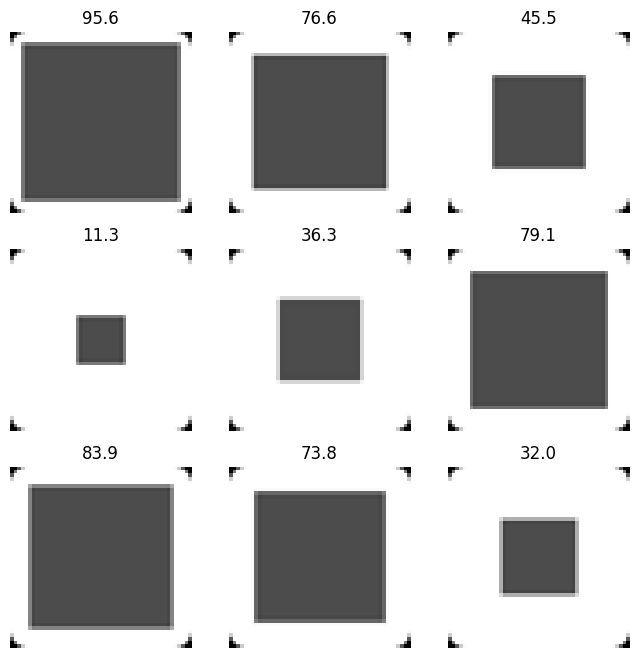

In [5]:
image = images[0][0]
# display(image)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx: int = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(str(label))
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [33]:
from torch import Tensor
import io


# Creating the PyTorch Dataset and DataLoader
class ImageDataset(Dataset):
    def __init__(self, zip_path: str):
        self.zip_path = zip_path
        manifest = archive.read("metadata.json")
        self.manifest = Manifest.model_validate_json(manifest)
        self.samples = [(sample.filename, sample.x) for sample in self.manifest.images]
        self.archive = None

    def _ensure_archive(self):
        if self.archive is None:
            self.archive = zipfile.ZipFile(self.zip_path, 'r')

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int) -> tuple[Tensor, float]:
        self._ensure_archive()
        filename, label = self.samples[index]
        img_bytes = self.archive.read(filename)
        # Convert to torch uint8 tensor for decode_image
        img_tensor = torch.tensor(list(img_bytes), dtype=torch.uint8)
        img = torchvision.io.decode_image(img_tensor, mode=ImageReadMode.GRAY)
        return img, label


dataset = ImageDataset(zip_path=glyph_location)
data_loader = torch.utils.data.DataLoader(dataset)

Now that we've imported the zip file and parsed the manifest, we can build our NN

In [26]:
class GlyphRegressor(nn.Module):
    def __init__(self):
        """
        image_size: assume images are square (image_size x image_size)
        """
        super().__init__()
        # input shape: (1, )
        self.pool = nn.MaxPool2d(2, 2)
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2)
        # self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=0)
        # self.fc1 = nn.Linear(32 * (image_size // 2) * (image_size // 2), 64)
        # self.fc2 = nn.Linear(64, 1)  # single scalar output

    def forward(self, x):
        # x: (batch_size, 1, H, W)
        # x = F.relu(self.conv1(x))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(x.size(0), -1)  # flatten
        # x = F.relu(self.fc1(x))
        # x = self.fc2(x)  # raw output
        # x = torch.sigmoid(x) * 100  # scale 0-100
        x = self.pool(x)
        return x


In [6]:
# Creating a da

/tmp/ipykernel_93470/502842280.py:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  img_tensor = torch.from_numpy(img_array).float() / 255.0


AttributeError: module 'triton' has no attribute 'language'

Looking at the code, I can see there's a typo in the comment and an incomplete line. The code has `# <caret>` followed by a stray `s` character that needs to be removed.



In [7]:
# Convert grayscale images to tensors
X = []
y = []
for idx, img_bytes in enumerate(grayscale_images):
    # Convert bytes to numpy array and reshape
    img_array = np.frombuffer(img_bytes, dtype=np.uint8).reshape(image_size, image_size)
    # Normalize to [0, 1]
    img_tensor = torch.from_numpy(img_array).float() / 255.0
    # Add channel dimension
    img_tensor = img_tensor.unsqueeze(0)
    X.append(img_tensor)
    # Get the corresponding x value from manifest
    y.append(manifest.images[idx].x)

X = torch.stack(X).to(device)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)

# Initialize the model
model = GlyphRegressor(image_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    # Mini-batch training
    for i in range(0, len(X), batch_size):
        batch_X = X[i:i + batch_size]
        batch_y = y[i:i + batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(X):.4f}')

print("Training completed!")

# Save the model
torch.save(model.state_dict(), 'models/glyph_regressor.pth')
print("Model saved to models/glyph_regressor.pth")


AttributeError: module 'triton' has no attribute 'language'